# Data Importing

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
import keras_tuner as kt
from keras_tuner import HyperModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, accuracy_score, f1_score, roc_auc_score, average_precision_score
import seaborn as sns

# Load Images

In [2]:
def limit_data(data_dir, n=100):
    data = []
    for i in os.listdir(data_dir):
        for k, j in enumerate(os.listdir(data_dir+'/'+i)):
            if k > n:
                continue
            data.append((f'{data_dir}/{i}/{j}', i))
    return pd.DataFrame(data, columns=['filename', 'class'])

base_path = '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)

image_size = (128, 128)

batch_size = 32

# Limit the data for training, validation, and testing datasets
train_df = limit_data(base_path+'train', 50000)
valid_df = limit_data(base_path+'valid', 10000)
test_df = limit_data(base_path+'test', 10000)

# Create data generators with the new image size
train_dataset = image_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary")

valid_dataset = image_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary")

test_dataset = image_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="class",
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode="binary")

Found 100000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [3]:
train_dataset.class_indices
valid_dataset.class_indices
test_dataset.class_indices

{'fake': 0, 'real': 1}

# CNN 1 - Baseline Model
Accuracy: 88.235%

In [19]:
def create_model():
    # Initialize the CNN model
    model = Sequential()

    # Add convolutional layers with LeakyReLU activation, batch normalization, and max pooling
    model.add(Conv2D(32, (3,3), padding='same', activation='LeakyReLU', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='LeakyReLU'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    # Add fully connected layers with LeakyReLU activation and dropout for regularization
    model.add(Dense(128, activation='LeakyReLU'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create the model
model_cnn_1 = create_model()

# Print model summary
model_cnn_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)            

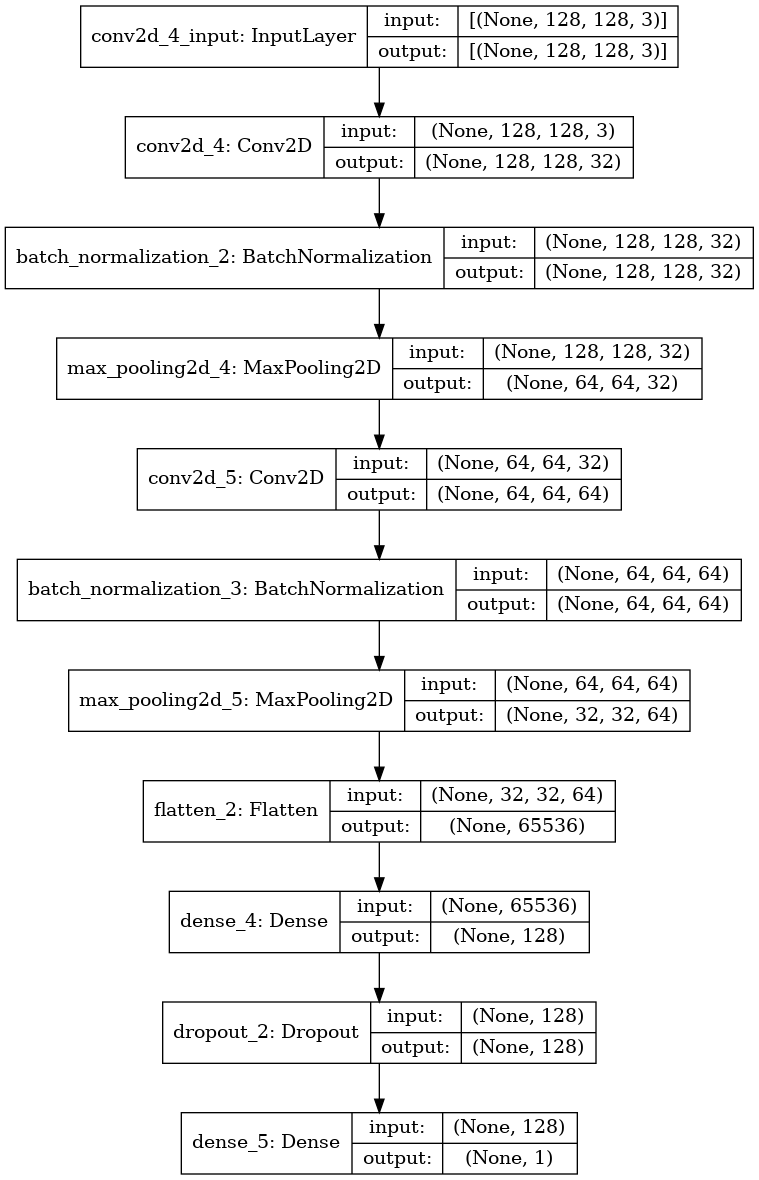

In [20]:
# Generate a graphical summary of the model architecture
plot_model(model_cnn_1, to_file='model_cnn_1.png', show_shapes=True, show_layer_names=True)

In [21]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_model_cnn_1 = model_cnn_1.fit(train_dataset,
                             epochs=10,
                             validation_data=valid_dataset,
                             steps_per_epoch=1000,
                             callbacks=[early_stopping])

Epoch 1/10
1000/1000 [==============================] - 497s 495ms/step - loss: 3.3027 - accuracy: 0.6948 - val_loss: 0.4863 - val_accuracy: 0.7787
Epoch 2/10
1000/1000 [==============================] - 495s 494ms/step - loss: 0.4080 - accuracy: 0.8174 - val_loss: 0.3534 - val_accuracy: 0.8497
Epoch 3/10
1000/1000 [==============================] - 493s 493ms/step - loss: 0.3761 - accuracy: 0.8370 - val_loss: 0.4447 - val_accuracy: 0.8149
Epoch 4/10
1000/1000 [==============================] - 494s 494ms/step - loss: 0.3319 - accuracy: 0.8613 - val_loss: 0.3307 - val_accuracy: 0.8627
Epoch 5/10
1000/1000 [==============================] - 507s 507ms/step - loss: 0.2923 - accuracy: 0.8769 - val_loss: 0.2967 - val_accuracy: 0.8702
Epoch 6/10
1000/1000 [==============================] - 503s 503ms/step - loss: 0.2518 - accuracy: 0.8979 - val_loss: 0.2096 - val_accuracy: 0.9176
Epoch 7/10
1000/1000 [==============================] - 516s 516ms/step - loss: 0.2166 - accuracy: 0.9156 - val_

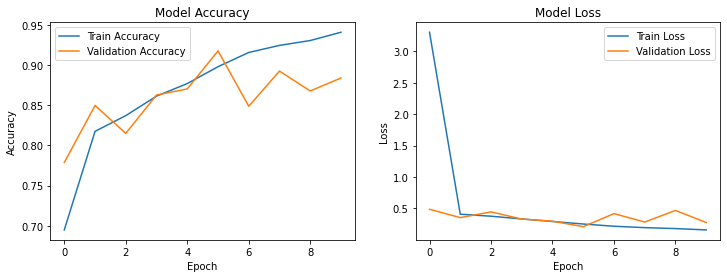

In [32]:
# Access the history to retrieve the training and validation loss and accuracy
train_loss = history_model_cnn_1.history['loss']
val_loss = history_model_cnn_1.history['val_loss']
train_accuracy = history_model_cnn_1.history['accuracy']
val_accuracy = history_model_cnn_1.history['val_accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy
ax1.plot(train_accuracy, label='Train Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot training & validation loss
ax2.plot(train_loss, label='Train Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

# Show the plots
plt.show()

In [24]:
# Save model to current directory with desired filename
model_cnn_1.save('model_cnn_1.keras')

# Define Kaggle working directory
kaggle_working_path = '/kaggle/working/'

# Move model file to Kaggle working directory
os.rename('model_cnn_1.keras', os.path.join(kaggle_working_path, 'model_cnn_1.keras'))

In [61]:
# Specify the path to your saved model in the Kaggle working directory
model_path = '/kaggle/working/model_cnn_1.keras'

# Load the model
model_cnn_1 = load_model(model_path)

In [62]:
# Reset test dataset generator to avoid shuffling issues
test_dataset.reset()

# Predict probabilities for the test dataset
y_pred_probs = model_cnn_1.predict(test_dataset)

# Convert probabilities to binary predictions
predictions_binary = (y_pred_probs > 0.5).astype('int').reshape(-1)

# Get the true class labels
true_labels = test_dataset.classes

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predictions_binary)
f1 = f1_score(true_labels, predictions_binary)
auc_roc = roc_auc_score(true_labels, predictions_binary)
auc_prc = average_precision_score(true_labels, predictions_binary)

20000/20000 [==============================] - 257s 13ms/step


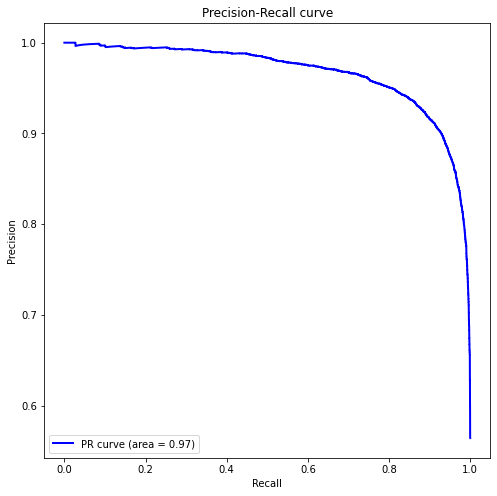

Area under the Precision-Recall curve (AUC): 0.9668122809788215


In [64]:
# Step 1: Get predicted probabilities for the test dataset
y_pred_probs = model_cnn_1.predict(test_dataset)
true_labels = test_dataset.classes

# Step 2: Calculate precision, recall, and AUC
precision, recall, _ = precision_recall_curve(true_labels, y_pred_probs)
prc_auc = auc(recall, precision)

# Step 3: Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

# Print the area under the curve
print("Area under the Precision-Recall curve (AUC):", prc_auc)

Accuracy: 0.88235
F1 Score: 0.8728176855305118
AUC-ROC: 0.88235
AUC-PRC: 0.8631447947300317
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.96      0.89     10000
        real       0.95      0.81      0.87     10000

    accuracy                           0.88     20000
   macro avg       0.89      0.88      0.88     20000
weighted avg       0.89      0.88      0.88     20000

Confusion Matrix:
[[9573  427]
 [1926 8074]]


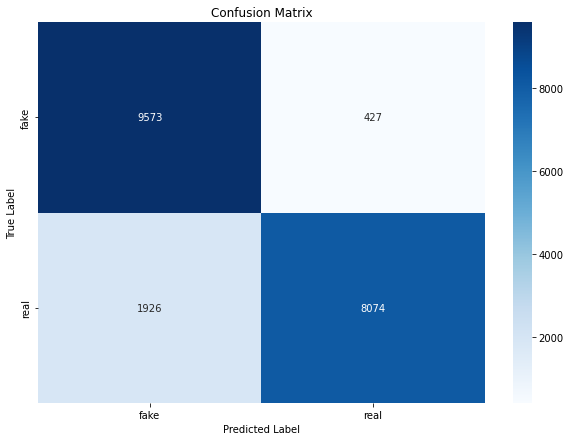

In [65]:
# Compute accuracy
accuracy = accuracy_score(true_labels, predictions_binary)

# Compute F1 score
f1 = f1_score(true_labels, predictions_binary)

# Compute AUC-ROC
auc_roc = roc_auc_score(true_labels, predictions_binary)

# Compute AUC-PRC
auc_prc = average_precision_score(true_labels, predictions_binary)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")
print(f"AUC-PRC: {auc_prc}")

# Generate the classification report
class_report = classification_report(true_labels, predictions_binary, target_names=test_dataset.class_indices.keys())
print("Classification Report:")
print(class_report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# CNN 2 - Improved Model
Accuracy: 91.52%

Simplified the model by removing batch normalisation and changing activation to RELU

In [47]:
def create_model():
    # Initialize the CNN model
    model = Sequential()

    # Add convolutional layers with ReLU activation, and max pooling
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    # Add fully connected layers with ReLU activation and dropout for regularization
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create the model
model_cnn_2 = create_model()

# Print model summary
model_cnn_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

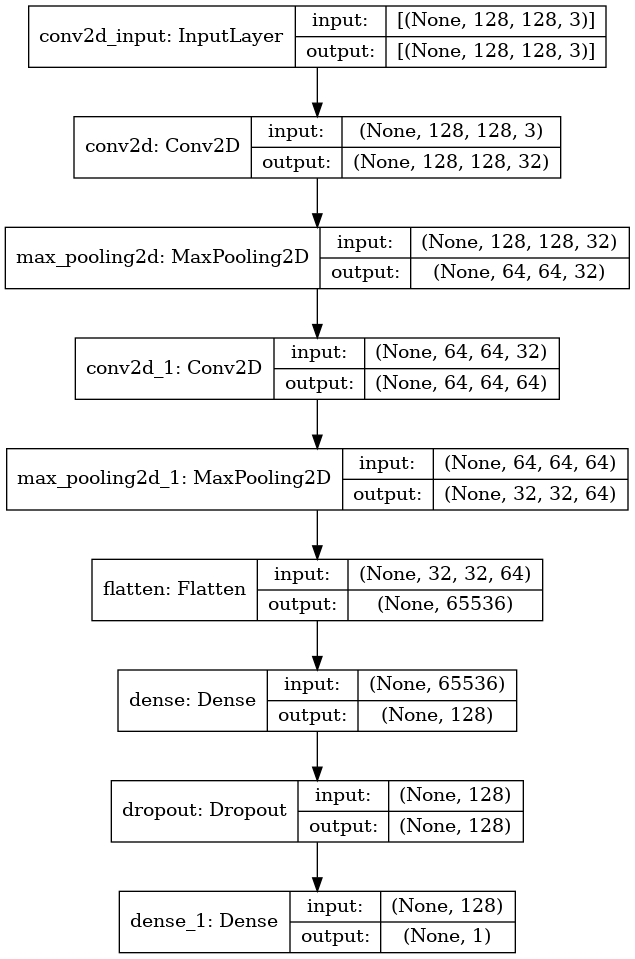

In [4]:
# Generate a graphical summary of the model architecture
plot_model(model_cnn_2, to_file='model_cnn_2.png', show_shapes=True, show_layer_names=True)

In [48]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_model_cnn_2 = model_cnn_2.fit(train_dataset,
                             epochs=10,
                             validation_data=valid_dataset,
                             steps_per_epoch=1000,
                             callbacks=[early_stopping])

Epoch 1/10
1000/1000 [==============================] - 409s 408ms/step - loss: 0.5764 - accuracy: 0.6980 - val_loss: 0.4755 - val_accuracy: 0.7755
Epoch 2/10
1000/1000 [==============================] - 402s 402ms/step - loss: 0.4533 - accuracy: 0.7888 - val_loss: 0.3988 - val_accuracy: 0.8190
Epoch 3/10
1000/1000 [==============================] - 455s 455ms/step - loss: 0.3867 - accuracy: 0.8256 - val_loss: 0.3348 - val_accuracy: 0.8555
Epoch 4/10
1000/1000 [==============================] - 409s 409ms/step - loss: 0.3339 - accuracy: 0.8550 - val_loss: 0.2956 - val_accuracy: 0.8774
Epoch 5/10
1000/1000 [==============================] - 408s 407ms/step - loss: 0.2892 - accuracy: 0.8785 - val_loss: 0.2655 - val_accuracy: 0.8903
Epoch 6/10
1000/1000 [==============================] - 420s 420ms/step - loss: 0.2553 - accuracy: 0.8940 - val_loss: 0.2432 - val_accuracy: 0.9018
Epoch 7/10
1000/1000 [==============================] - 422s 422ms/step - loss: 0.2284 - accuracy: 0.9076 - val_

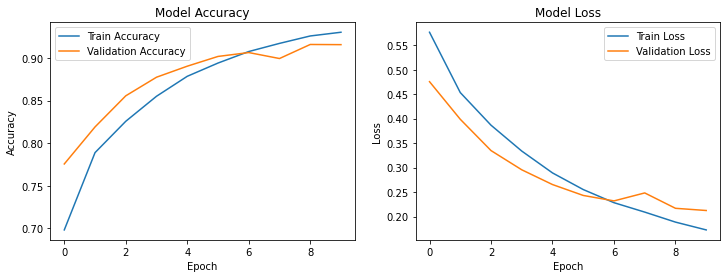

In [52]:
# Access the history to retrieve the training and validation loss and accuracy
train_loss = history_model_cnn_2.history['loss']
val_loss = history_model_cnn_2.history['val_loss']
train_accuracy = history_model_cnn_2.history['accuracy']
val_accuracy = history_model_cnn_2.history['val_accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy
ax1.plot(train_accuracy, label='Train Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot training & validation loss
ax2.plot(train_loss, label='Train Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

# Show the plots
plt.show()

In [54]:
# Save model to current directory with desired filename
model_cnn_2.save('model_cnn_2.keras')

# Define Kaggle working directory
kaggle_working_path = '/kaggle/working/'

# Move model file to Kaggle working directory
os.rename('model_cnn_2.keras', os.path.join(kaggle_working_path, 'model_cnn_2.keras'))

In [55]:
# Specify the path to your saved model in the Kaggle working directory
model_path = '/kaggle/working/model_cnn_2.keras'

# Load the model
model_cnn_2 = load_model(model_path)

In [56]:
# Reset test dataset generator to avoid shuffling issues
test_dataset.reset()

# Predict probabilities for the test dataset
y_pred_probs = model_cnn_2.predict(test_dataset)

# Convert probabilities to binary predictions
predictions_binary = (y_pred_probs > 0.5).astype('int').reshape(-1)

# Get the true class labels
true_labels = test_dataset.classes

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predictions_binary)
f1 = f1_score(true_labels, predictions_binary)
auc_roc = roc_auc_score(true_labels, predictions_binary)
auc_prc = average_precision_score(true_labels, predictions_binary)

20000/20000 [==============================] - 191s 10ms/step


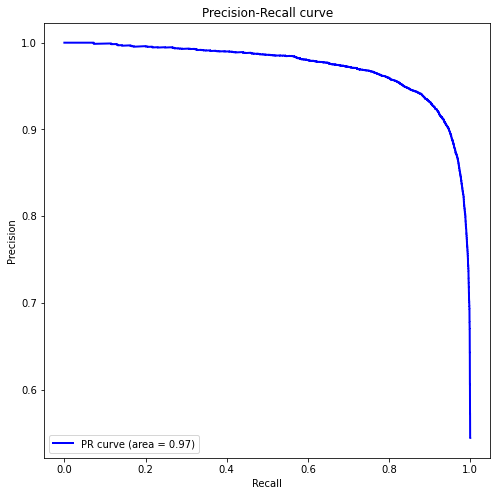

Area under the Precision-Recall curve (AUC): 0.9717546806079124


In [59]:
# Calculate precision, recall, and AUC
precision, recall, _ = precision_recall_curve(true_labels, y_pred_probs)
prc_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

# Print the area under the curve
print("Area under the Precision-Recall curve (AUC):", prc_auc)

Accuracy: 0.9152
F1 Score: 0.9132569558101474
AUC-ROC: 0.9152
AUC-PRC: 0.8880763819095479
Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.94      0.92     10000
        real       0.93      0.89      0.91     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Confusion Matrix:
[[9376  624]
 [1072 8928]]


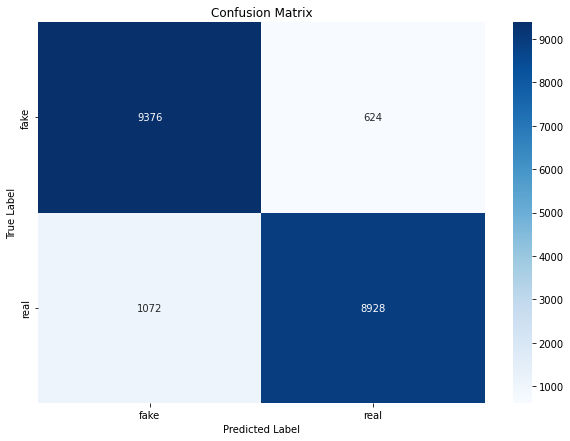

In [60]:
# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")
print(f"AUC-PRC: {auc_prc}")

# Generate the classification report
class_report = classification_report(true_labels, predictions_binary, target_names=test_dataset.class_indices.keys())
print("Classification Report:")
print(class_report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Hyperparameter tuning with Random Search - 1

Created HyperModel with varied options and large range for random search

Final result, where val accuracy ahieved 0.83165, however, model is unable to learn

In [3]:
X_train = []
y_train = []
num_samples = 10000
samples_collected = 0

while samples_collected < num_samples:
    X_batch, y_batch = next(train_dataset)
    num_samples_batch = min(num_samples - samples_collected, len(X_batch))
    X_train.append(X_batch[:num_samples_batch])
    y_train.append(y_batch[:num_samples_batch])
    samples_collected += num_samples_batch

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

In [4]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=512, step=32), 
                         (3, 3), 
                         padding='same', 
                         activation=hp.Choice('conv_activation', values=['relu', 'elu', 'tanh', 'sigmoid']), 
                         input_shape=self.input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=512, step=32), 
                         (3, 3), 
                         padding='same', 
                         activation=hp.Choice('conv_activation', values=['relu', 'elu', 'tanh', 'sigmoid'])))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(hp.Int('dense_units', min_value=64, max_value=1024, step=64), activation='relu'))
        model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.7, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(loss='binary_crossentropy', optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']), metrics=['accuracy'])
        
        return model

# Create an instance of the hypermodel
tuner_cnn_1 = MyHyperModel(input_shape=(128, 128, 3))

In [5]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Initialize the random search tuner
tuner_cnn_1 = kt.RandomSearch(tuner_cnn_1, objective='val_accuracy', max_trials=10)

# Perform hyperparameter tuning
tuner_cnn_1.search(X_train, y_train, epochs=20, validation_data=valid_dataset, callbacks=[early_stopping])

Trial 10 Complete [00h 09m 13s]
val_accuracy: 0.8065999746322632

Best val_accuracy So Far: 0.8316500186920166
Total elapsed time: 02h 08m 40s


In [11]:
# Retrieve hyperparameters and validation metrics for all trials
all_trials = tuner_cnn_1.oracle.get_best_trials(10)

# Initialize a list to store trial data
trial_data = []

# Extract trial data
for i, trial in enumerate(all_trials, start=1):
    hyperparameters = trial.hyperparameters.values
    score = trial.score
    trial_data.append({**hyperparameters, 'score': score})

# Create a DataFrame from trial data
df = pd.DataFrame(trial_data)
df.index = range(1, len(df) + 1)

# Display the DataFrame
display(df)

,conv1_units,conv_activation,conv2_units,dense_units,dropout,optimizer,score
1,96,elu,448,960,0.7,adam,0.83165
2,64,tanh,192,320,0.2,rmsprop,0.82240
3,224,elu,320,640,0.4,adam,0.81520
4,64,tanh,128,896,0.3,sgd,0.81385
5,320,relu,224,640,0.4,rmsprop,0.80660
6,256,relu,224,320,0.6,sgd,0.79540
7,352,relu,320,256,0.3,adam,0.76225
8,416,relu,192,128,0.2,adam,0.74420
9,384,tanh,448,1024,0.6,rmsprop,0.50000
10,128,sigmoid,256,384,0.2,sgd,0.50000


In [3]:
# Define a function to create the model with the best hyperparameters
def create_model(best_hyperparameters):
    
    model = Sequential()
    
    model.add(Conv2D(best_hyperparameters['conv1_units'], (3, 3), padding='same', activation=best_hyperparameters['conv_activation'], 
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(best_hyperparameters['conv2_units'], (3, 3), padding='same', activation=best_hyperparameters['conv_activation']))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    
    model.add(Dense(best_hyperparameters['dense_units'], activation='relu'))
    model.add(Dropout(best_hyperparameters['dropout']))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Apply best_hyperparameters from hyperparameter tuning
best_hyperparameters = {
    'conv1_units': 96,
    'conv_activation': 'elu',
    'conv2_units': 448,
    'dense_units': 960,
    'dropout': 0.7
}

# Create the model with the best hyperparameters
tuned_model = create_model(best_hyperparameters)

# Print model summary
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 96)      2688      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 448)       387520    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 448)       0         
_________________________________________________________________
flatten (Flatten)            (None, 458752)            0         
_________________________________________________________________
dense (Dense)                (None, 960)               440402880 
_________________________________________________________________
dropout (Dropout)            (None, 960)               0

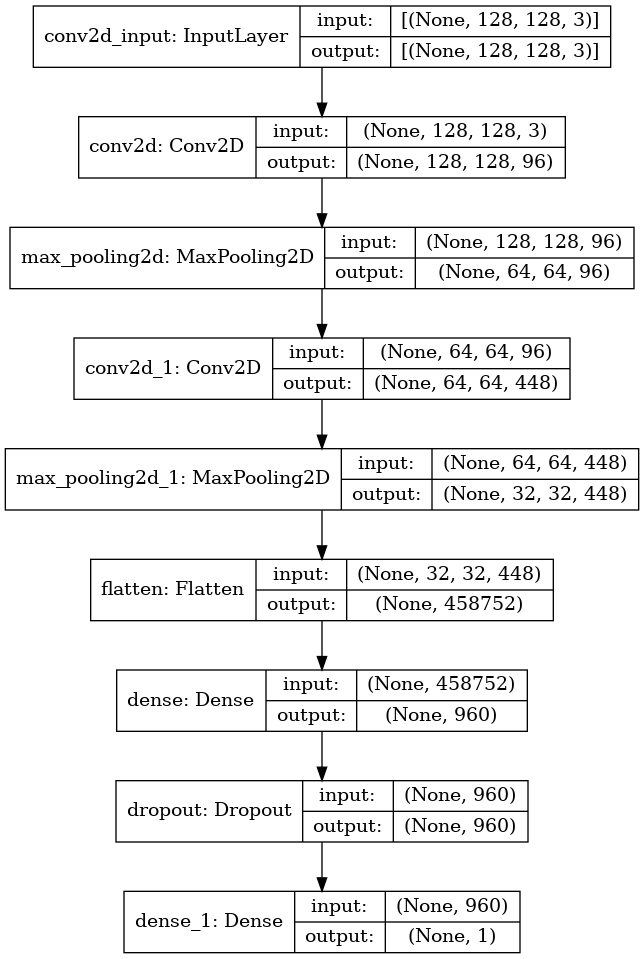

In [4]:
# Generate a graphical summary of the model architecture
plot_model(tuned_model, to_file='tuned_model.png', show_shapes=True, show_layer_names=True)

In [5]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_tuned = tuned_model.fit(train_dataset,
                             epochs=10,
                             validation_data=valid_dataset,
                             steps_per_epoch=1000,
                             callbacks=[early_stopping])

Epoch 1/10
1000/1000 [==============================] - 383s 376ms/step - loss: 1.0904 - accuracy: 0.6229 - val_loss: 0.5755 - val_accuracy: 0.7133
Epoch 2/10
1000/1000 [==============================] - 243s 243ms/step - loss: 0.6667 - accuracy: 0.5809 - val_loss: 0.6978 - val_accuracy: 0.5000
Epoch 3/10
1000/1000 [==============================] - 203s 203ms/step - loss: 0.6933 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 4/10
1000/1000 [==============================] - 179s 179ms/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
1000/1000 [==============================] - 161s 161ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 6/10
1000/1000 [==============================] - 151s 151ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.5000


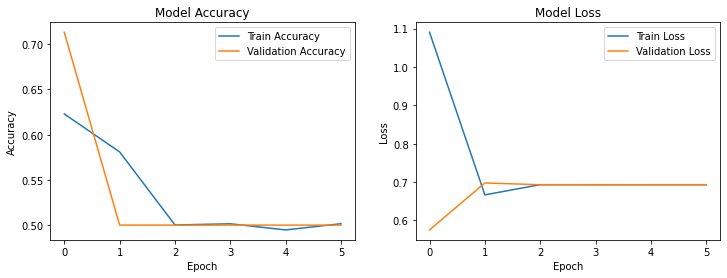

In [6]:
# Access the history to retrieve the training and validation loss and accuracy
train_loss = history_tuned.history['loss']
val_loss = history_tuned.history['val_loss']
train_accuracy = history_tuned.history['accuracy']
val_accuracy = history_tuned.history['val_accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy
ax1.plot(train_accuracy, label='Train Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot training & validation loss
ax2.plot(train_loss, label='Train Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

# Show the plots
plt.show()

# Hyperparameter tuning with Random Search - 2

Reduced train dataset volume

HyperModel now has a more limited range of value and options

Achieving decent val_acc score of 0.73385

In [4]:
X_train = []
y_train = []
num_samples = 5000
samples_collected = 0

while samples_collected < num_samples:
    X_batch, y_batch = next(train_dataset)
    num_samples_batch = min(num_samples - samples_collected, len(X_batch))
    X_train.append(X_batch[:num_samples_batch])
    y_train.append(y_batch[:num_samples_batch])
    samples_collected += num_samples_batch

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

In [9]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=256, step=32), 
                         (3, 3), 
                         padding='same', 
                         activation=hp.Choice('conv_activation', values=['relu', 'elu']), 
                         input_shape=self.input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=256, step=32), 
                         (3, 3), 
                         padding='same', 
                         activation=hp.Choice('conv_activation', values=['relu', 'elu'])))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'))
        model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model

# Create an instance of the hypermodel
tuner_cnn_2 = MyHyperModel(input_shape=(128, 128, 3))

In [10]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Initialize the random search tuner
tuner_cnn_2 = kt.RandomSearch(tuner_cnn_2, objective='val_accuracy', max_trials=5)

# Perform hyperparameter tuning
tuner_cnn_2.search(X_train, y_train, epochs=10, validation_data=valid_dataset, callbacks=[early_stopping])

Trial 5 Complete [00h 08m 31s]
val_accuracy: 0.7338500022888184

Best val_accuracy So Far: 0.7338500022888184
Total elapsed time: 00h 36m 21s


In [11]:
# Retrieve hyperparameters and validation metrics for all trials
all_trials = tuner_cnn_2.oracle.get_best_trials(5)

# Initialize a list to store trial data
trial_data = []

# Extract trial data
for i, trial in enumerate(all_trials, start=1):
    hyperparameters = trial.hyperparameters.values
    score = trial.score
    trial_data.append({**hyperparameters, 'score': score})

# Create a DataFrame from trial data
df = pd.DataFrame(trial_data)
df.index = range(1, len(df) + 1)
print(df)

# Find the index of the trial with the highest score
best_trial_index = df['score'].idxmax()
print(f"\nThe best validation accuracy is Trial #{best_trial_index}")

   conv1_units conv_activation  conv2_units  dense_units  dropout    score
1           96            relu          128           64      0.4  0.73385
2          128            relu          192          320      0.4  0.73365
3          128            relu          128          192      0.3  0.73260
4          192            relu           96          192      0.3  0.72730
5          128            relu          192          384      0.2  0.71515

The best validation accuracy is Trial #1


# Hyperparameter tuning with Random Search - 3

Model has an even more focused sets of values and selected relu as convulation layer's activation

Achieved higher val_acc score comparing to previous search at 0.74865

In [4]:
X_train = []
y_train = []
num_samples = 5000
samples_collected = 0

while samples_collected < num_samples:
    X_batch, y_batch = next(train_dataset)
    num_samples_batch = min(num_samples - samples_collected, len(X_batch))
    X_train.append(X_batch[:num_samples_batch])
    y_train.append(y_batch[:num_samples_batch])
    samples_collected += num_samples_batch

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

In [11]:
# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32), 
                     (3, 3), 
                     padding='same', 
                     activation='relu', 
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), 
                     (3, 3), 
                     padding='same', 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [12]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Initialize the random search tuner
tuner_cnn_3 = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=5)

# Perform hyperparameter tuning
tuner_cnn_3.search(X_train, y_train, epochs=10, validation_data=valid_dataset, callbacks=[early_stopping])

Trial 5 Complete [00h 17m 27s]
val_accuracy: 0.7396500110626221

Best val_accuracy So Far: 0.7486500144004822
Total elapsed time: 02h 41m 00s


In [13]:
best_hyperparameters = tuner_cnn_3.oracle.get_best_trials(5)[0].hyperparameters
best_validation_acc = tuner_cnn_3.oracle.get_best_trials(5)[0].score

print("Best Hyperparameters:")
print(best_hyperparameters.values)
print("Best Validation Accuracy:", best_validation_acc)

Best Hyperparameters:
{'conv1_units': 96, 'conv2_units': 96, 'dense_units': 256, 'dropout': 0.2}
Best Validation Accuracy: 0.7486500144004822


In [14]:
# Retrieve hyperparameters and validation metrics for all trials
all_trials = tuner_cnn_3.oracle.get_best_trials(5)

# Initialize a list to store trial data
trial_data = []

# Extract trial data
for i, trial in enumerate(all_trials, start=1):
    hyperparameters = trial.hyperparameters.values
    score = trial.score
    trial_data.append({**hyperparameters, 'score': score})

# Create a DataFrame from trial data
df = pd.DataFrame(trial_data)
df.index = range(1, len(df) + 1)
print(df)

# Find the index of the trial with the highest score
best_trial_index = df['score'].idxmax()
print(f"\nThe best validation accuracy is Trial #{best_trial_index}")

   conv1_units  conv2_units  dense_units  dropout    score
1           96           96          256      0.2  0.74865
2           32           64          192      0.5  0.73965
3           64           32           64      0.3  0.73965
4           96           96          128      0.4  0.73130
5          128           32          192      0.5  0.71885

The best validation accuracy is Trial #1


# CNN 3 - Tuned Model

Applied Random Search 3's result into model

Accuracy: 92.41%

In [26]:
# Define a function to create the model with the best hyperparameters
def create_model(best_hyperparameters):
    # Initialize the CNN model
    model = Sequential()

    # Add convolutional layers with ReLU activation, and max pooling
    model.add(Conv2D(best_hyperparameters['conv1_units'], (3,3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(best_hyperparameters['conv2_units'], (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    # Add fully connected layers with ReLU activation and dropout for regularization
    model.add(Dense(best_hyperparameters['dense_units'], activation='relu'))
    model.add(Dropout(best_hyperparameters['dropout']))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Apply best_hyperparameters from hyperparameter tuning
best_hyperparameters = {
    'conv1_units': 96,
    'conv2_units': 96,
    'dense_units': 256,
    'dropout': 0.2
}

# Create the model with the best hyperparameters
tuned_cnn = create_model(best_hyperparameters)

# Print model summary
tuned_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 96)      2688      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 96)        83040     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 96)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               25166080  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

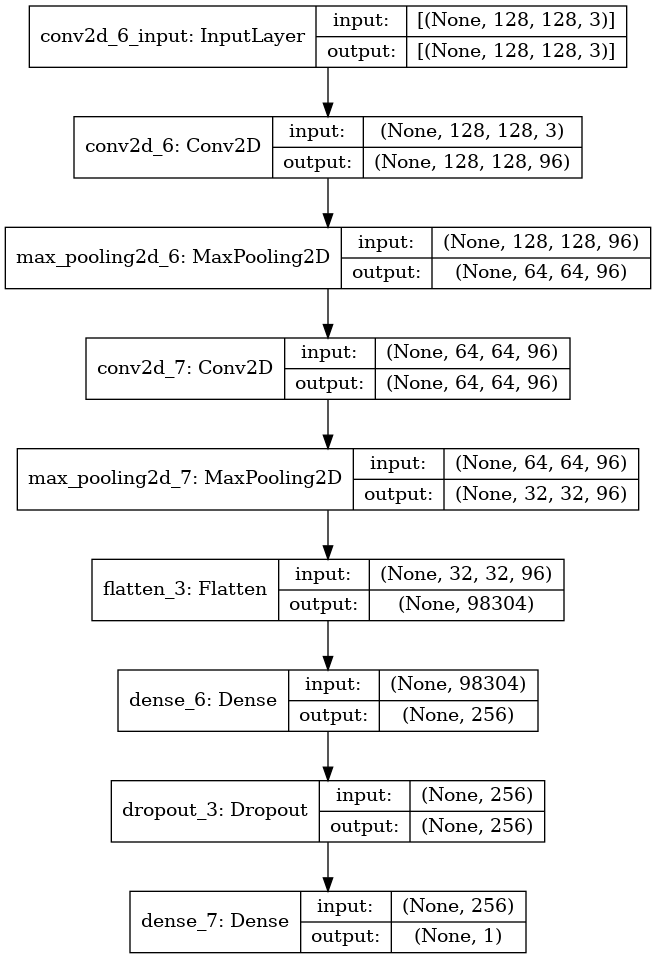

In [27]:
# Generate a graphical summary of the model architecture
plot_model(tuned_cnn, to_file='tuned_cnn.png', show_shapes=True, show_layer_names=True)

In [28]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_tuned_cnn = tuned_cnn.fit(train_dataset,
                             epochs=10,
                             validation_data=valid_dataset,
                             steps_per_epoch=1000,
                             callbacks=[early_stopping])

Epoch 1/10
1000/1000 [==============================] - 1354s 1s/step - loss: 0.6241 - accuracy: 0.6559 - val_loss: 0.5249 - val_accuracy: 0.7367
Epoch 2/10
1000/1000 [==============================] - 1343s 1s/step - loss: 0.4583 - accuracy: 0.7854 - val_loss: 0.4068 - val_accuracy: 0.8152
Epoch 3/10
1000/1000 [==============================] - 1346s 1s/step - loss: 0.3627 - accuracy: 0.8420 - val_loss: 0.3806 - val_accuracy: 0.8303
Epoch 4/10
1000/1000 [==============================] - 1341s 1s/step - loss: 0.2926 - accuracy: 0.8767 - val_loss: 0.3333 - val_accuracy: 0.8615
Epoch 5/10
1000/1000 [==============================] - 1328s 1s/step - loss: 0.2432 - accuracy: 0.9027 - val_loss: 0.2614 - val_accuracy: 0.8941
Epoch 6/10
1000/1000 [==============================] - 1329s 1s/step - loss: 0.1929 - accuracy: 0.9245 - val_loss: 0.2683 - val_accuracy: 0.8926
Epoch 7/10
1000/1000 [==============================] - 1322s 1s/step - loss: 0.1651 - accuracy: 0.9357 - val_loss: 0.2301 -

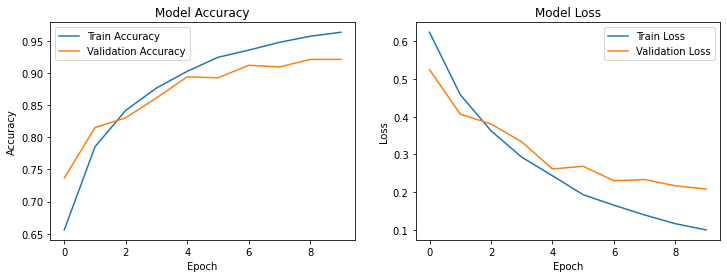

In [32]:
# Access the history to retrieve the training and validation loss and accuracy
train_loss = history_tuned_cnn.history['loss']
val_loss = history_tuned_cnn.history['val_loss']
train_accuracy = history_tuned_cnn.history['accuracy']
val_accuracy = history_tuned_cnn.history['val_accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy
ax1.plot(train_accuracy, label='Train Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot training & validation loss
ax2.plot(train_loss, label='Train Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

# Show the plots
plt.show()

In [42]:
# Save model to current directory with desired filename
tuned_cnn.save('tuned_cnn.keras')

# Define Kaggle working directory
kaggle_working_path = '/kaggle/working/'

# Move model file to Kaggle working directory
os.rename('tuned_cnn.keras', os.path.join(kaggle_working_path, 'tuned_cnn.keras'))

In [43]:
# Specify the path to your saved model in the Kaggle working directory
model_path = '/kaggle/working/tuned_cnn.keras'

# Load the model
tuned_cnn = load_model(model_path)

In [35]:
# Reset test dataset generator to avoid shuffling issues
test_dataset.reset()

# Predict probabilities for the test dataset
y_pred_probs = tuned_cnn.predict(test_dataset)

# Convert probabilities to binary predictions
predictions_binary = (y_pred_probs > 0.5).astype('int').reshape(-1)

# Get the true class labels
true_labels = test_dataset.classes

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predictions_binary)
f1 = f1_score(true_labels, predictions_binary)
auc_roc = roc_auc_score(true_labels, predictions_binary)
auc_prc = average_precision_score(true_labels, predictions_binary)

20000/20000 [==============================] - 450s 22ms/step


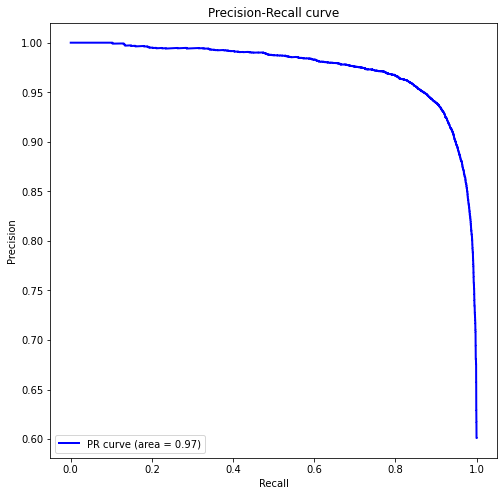

Area under the Precision-Recall curve (AUC): 0.9744712925096025


In [40]:
# Calculate precision, recall, and AUC
precision, recall, _ = precision_recall_curve(true_labels, y_pred_probs)
prc_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

# Print the area under the curve
print("Area under the Precision-Recall curve (AUC):", prc_auc)

Accuracy: 0.9241
F1 Score: 0.9233797698364627
AUC-ROC: 0.9240999999999999
AUC-PRC: 0.895356981247452
Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.93      0.92     10000
        real       0.93      0.91      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Confusion Matrix:
[[9335  665]
 [ 853 9147]]


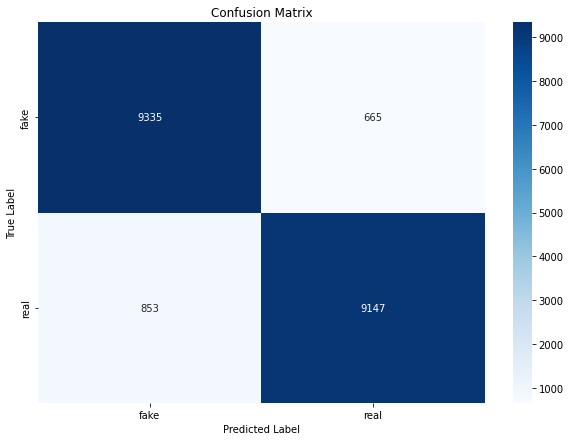

In [41]:
# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")
print(f"AUC-PRC: {auc_prc}")

# Generate the classification report
class_report = classification_report(true_labels, predictions_binary, target_names=test_dataset.class_indices.keys())
print("Classification Report:")
print(class_report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()